In [21]:
import requests
import cv2
from matplotlib import pyplot as plt 
import numpy as np

from utils import *

## Feature Matching
This script identifies keypoints and generates descriptors in two images using detectors like SIFT or other options available in OpenCV. The subsequent step involves matching each keypoint in the first image with corresponding points in the second image using a brute force matcher. Specifically, for each keypoint in the first image, the script calculates the distances between the descriptors of that point and all the descriptors in the second image. The keypoint in the second image with the minimum distance is considered a match. The matches are then sorted based on distance, and the script plots the top few matches for visualization.

[Additional reading](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html)

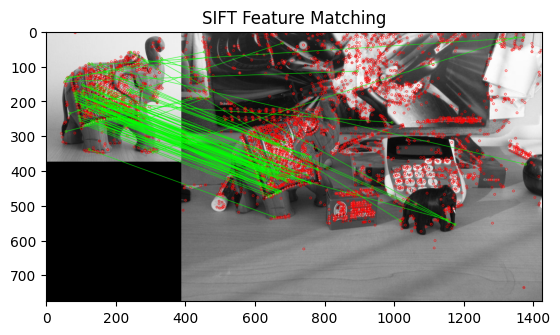

In [22]:
# Load images
image1 = cv2.imread('data/images/elephantImage.png', cv2.IMREAD_GRAYSCALE)  # if the image is grayscale and we remove the second parameter, it'll just copy that channel for BGR
image2 = cv2.imread('data/images/sceneImage.png', cv2.IMREAD_GRAYSCALE)

# Initialize SIFT detector
feat = cv2.SIFT_create()

# Find the keypoints and descriptors with ORB
keypoints1, descriptors1 = feat.detectAndCompute(image1, None)              # number of keypoints = number of descriptors
                                                                            # descriptors1[0,:] --> descriptor for the first keypoint?
keypoints2, descriptors2 = feat.detectAndCompute(image2, None)

# Create BFMatcher (Brute Force Matcher)
bf = cv2.BFMatcher()                                                        # applies the distance metric we have between each feature of the first image with all the features of the second image
                                                                            # By default, it uses NORM?

                                                                            # takes the one that's the closest for each of the features 
                                                                            # --> returned in 'matches' 

# Match descriptors
matches = bf.match(descriptors1, descriptors2)                              # a list 
                                                                            # matches[i].queryIdx (first image)    /      matches[i].trainIdx (second image)
                                                                            # matches[0].trainIdx --> 61 
                                                                            # This means Feature 0 from the first image matched with Feature 61 of the second image

# Sort them in ascending order of distance 
matches = sorted(matches, key=lambda x: x.distance)                         # key --> what do we want to match based on?

# Draw matches (the first 100)
img_matches = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:100], 
                              cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, 
                              singlePointColor=(255, 0, 0), matchColor=(0, 255, 0))     # not all of them are necessarily correct
                                                                                        # that's why we limited it to the first 100 matches

# Plot the matches using Matplotlib
plt.imshow(img_matches)
plt.title('SIFT Feature Matching')
plt.show()

In [23]:
matches[0].distance     # distance between descriptors
matches[0].trainIdx     # index of the descriptor in train descriptors
matches[0].queryIdx     # index of the descriptor in query descriptors
matches[0].imgIdx       # index of the train image
keypoints1[746].pt

print(matches[0].queryIdx, matches[0].trainIdx)     # Feature 746 from Image 1 had the lowest distance to Feature 2923 from Image 2 (I think???)

746 2923


## Feature matching with ratio test
This script performs the same keypoint detection, descriptor generation, and matching process as the previous one. However, it introduces a ratio test during the matching phase. Instead of selecting the point with the minimum distance, it considers the ratio of the distances between the best and second-best matches. If this ratio is below a certain threshold, the match is considered valid. The script then proceeds to sort and visualize the matches based on this ratio test.

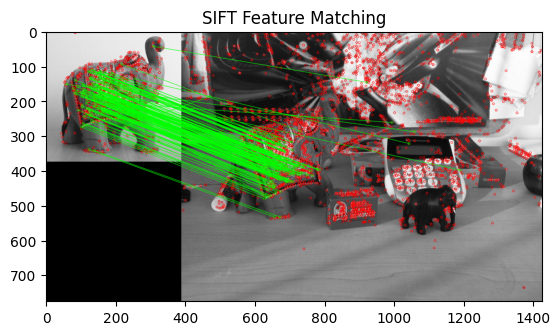

In [24]:
# Load images
image1 = cv2.imread('data/images/elephantImage.png', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('data/images/sceneImage.png', cv2.IMREAD_GRAYSCALE)

# Initialize SIFT detector
feat = cv2.SIFT_create()

# Find the keypoints and descriptors with ORB
keypoints1, descriptors1 = feat.detectAndCompute(image1, None)
keypoints2, descriptors2 = feat.detectAndCompute(image2, None)

# Create BFMatcher (Brute Force Matcher)
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1,descriptors2, k=2)           # k --> get the best two matches (not just the best 1 like in the prev case)
                                                                # if you add the parameter crossCheck --> matches features both ways (Img1 w/ Img 2 & Img2 w/ Img1)
                                                                #       use this if you want to only get matches that go both ways 

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:                            # good match (if the ratio is < 0.75) -- you can also do division but it becomes problematic 
        good.append(m)

# Draw matches
img_matches = cv2.drawMatches(image1, keypoints1, image2, keypoints2, good, 
                              cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, 
                              singlePointColor=(255, 0, 0), matchColor=(0, 255, 0))

# Plot the matches using Matplotlib
plt.imshow(img_matches)
plt.title('SIFT Feature Matching')
plt.show()

## Homography
This script applies a geometric transformation to an image using the provided homography matrix.

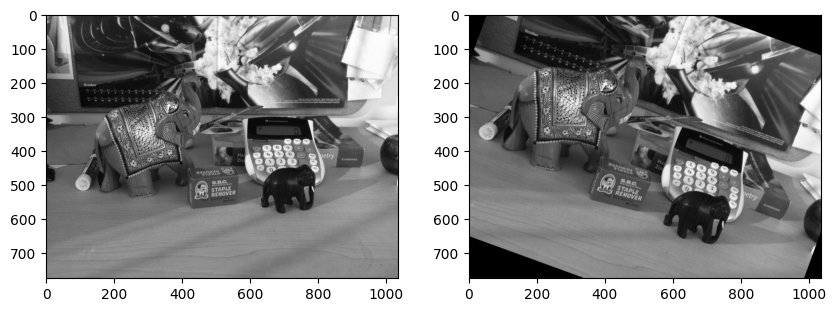

In [25]:
# Load the image
image = cv2.imread('data/images/sceneImage.png')

# Define scale, rotation, and shear factors
scale_factor = 1.1   
rotation_angle = 20     # in degrees 
shear_factor = 0

# Create transformation matrices
scale_matrix = np.array([[scale_factor, 0, 0],
                        [0, scale_factor, 0],
                        [0, 0, 1]])

rotation_angle_rad = np.radians(rotation_angle)         # convert angle to radians
rotation_matrix = np.array([[np.cos(rotation_angle_rad), -np.sin(rotation_angle_rad), 0],
                            [np.sin(rotation_angle_rad), np.cos(rotation_angle_rad), 0],
                            [0, 0, 1]])                                                    # rotates around (0, 0), not the center of the image

shear_matrix = np.array([[1, shear_factor, 0],
                        [shear_factor, 1, 0],
                        [0, 0, 1]])

# Combine the matrices to get the homography matrix
homography_matrix = np.dot(shear_matrix, np.dot(rotation_matrix, scale_matrix))            # scale is applied first, then rotation, then shear

# Make center of image as the origin --> moving the center of the image to the origin
T_matrix = np.array([[1, 0, image.shape[1]/2],        # translation in the x-direction --> width / 2 to move the center horizontally to the origin                                                   
                     [0, 1, image.shape[0]/2],        # translation in the y-direction --> height / 2 to move the center vertically to the origin
                     [0, 0, 1]])
homography_matrix = np.dot(np.dot(T_matrix, homography_matrix), np.linalg.inv(T_matrix))
# ^^ Performs the homography transformation in the new coordinate system (centered at the origin) then translates the transformed points back to their original positions
# Breakdown: 
#           np.dot(T_matrix, homography_matrix) --> applying T_matrix to the homography matrix 
#                                                   this moves the center of the image to the origin, effectively translating all pts in the image
#           np.linalg.inv(T_matrix) --> calculates the inverse of T_matrix; needed because after applying the homography transformation, 
#                                       we want to translate the transformed points back to their original positions.         


# Apply the transformation using warpPerspective
output_image = cv2.warpPerspective(image, homography_matrix, (image.shape[1], image.shape[0]))      # or use warpAffine
#           cv2.warpPerspective(src, M, dsize)
#                   src --> image you want to transform
#                   M --> transformation matrix (must be 3 x 3) -- defines how each point in the input image should be mapped to the output image
#                   dsize --> size of output image

#           cv2.warpAffine(src, M, dsize)
#                   M --> transformation matrix (must be 2 x 3)

# Display the original and transformed images
plt.figure(figsize = (10,8))
plt.subplot(121)
plt.imshow( image)
plt.subplot(122)
plt.imshow( output_image)

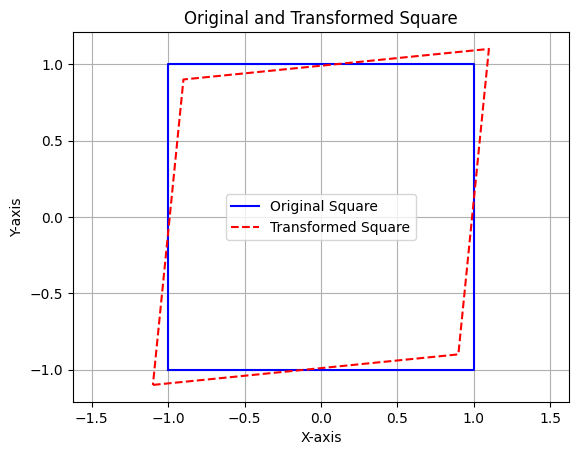

In [26]:
# Tranforming Points (In-class Exercise)
# Define the original square points (counter-clockwise order)
original_pts = np.array([[-1, -1], [1, -1], [1, 1], [-1, 1], [-1, -1]]).T
original_pts = np.row_stack((original_pts, np.ones(original_pts.shape[1])))

# Plot the original square
plt.plot(original_pts[0,:], original_pts[1,:], label='Original Square', color='blue')

# transformation Matrix
scale_factor = 1
rotation_angle = 0  # in degrees
shear_factor = .1

# Create transformation matrices
scale_matrix = np.array([[scale_factor, 0, 0],
                        [0, scale_factor, 0],
                        [0, 0, 1]])

rotation_angle_rad = np.radians(rotation_angle)
rotation_matrix = np.array([[np.cos(rotation_angle_rad), -np.sin(rotation_angle_rad), 0],
                            [np.sin(rotation_angle_rad), np.cos(rotation_angle_rad), 0],
                            [0, 0, 1]])

shear_matrix = np.array([[1, shear_factor, 0],
                        [shear_factor, 1, 0],
                        [0, 0, 1]])

# Combine the matrices to get the homography matrix
homography_matrix = np.dot(shear_matrix, np.dot(rotation_matrix, scale_matrix))

# Apply the transformation to each point
transformed_pts = np.dot(homography_matrix, original_pts)

# Plot the transformed square
plt.plot(transformed_pts[0,:], transformed_pts[1,:], label='Transformed Square', linestyle='dashed', color='red')

# Set plot properties
plt.title('Original and Transformed Square')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()

## Homographic Transformation
This script enables you to select four points in an image, facilitating the computation of a homography matrix. The homography matrix is then utilized to transform the image to create an image that simulates a top-down view from the selected perspective.

<img src="homograpy.jpg" alt="drawing" width="500"/>

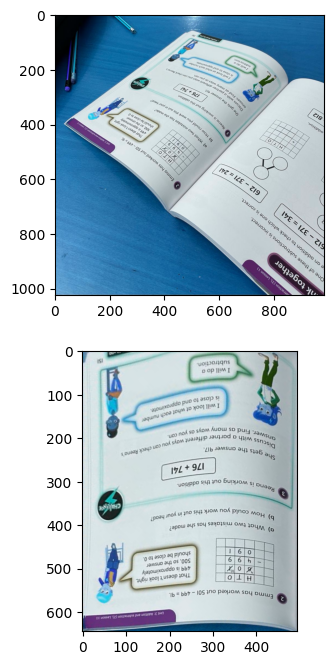

In [19]:
from matplotlib.backend_bases import MouseButton
import matplotlib
# matplotlib.use('Agg')     # this didn't run for me
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('data/images/book.jpeg')

%matplotlib qt
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Select four points in order: top-left, top-right, bottom-left and bottom-right')
# select point in this order -> top-left, top-right, bottom-left and bottom-right

# pts = plt.ginput(4) 
pts = plt.ginput(4,show_clicks=True, mouse_add=MouseButton.LEFT, mouse_pop=MouseButton.RIGHT, mouse_stop=MouseButton.MIDDLE) 
plt.close()

input_pts = np.array(pts, dtype=np.float32)             # convert selected pts to float 32

width = (np.linalg.norm(input_pts[0]-input_pts[1]), np.linalg.norm(input_pts[2]-input_pts[3]))      # computing the Euclidean distance between:
                                                                                                    #   - 1st & 2nd pts (top-left & top-right)
                                                                                                    #   - 3rd & 4th pts (bottom-left & bottom-right)
height = (np.linalg.norm(input_pts[0]-input_pts[2]), np.linalg.norm(input_pts[1]-input_pts[3]))     # computing the euclidean distance between:
                                                                                                    #   - 1st & 3rd pts (top-left & bottom-left)
                                                                                                    #   - 2nd & 4th pts (top-right & bottom-right)
width = int(np.max(width))
height = int(np.max(height))

output_pts = np.array([(0, 0),
          (width-1, 0),
          (0, height-1),
          (width-1,height-1)], np.float32)              # coordinates of the four corners of the output image (form a rectangle)    

# compute the homography matrix
H = cv2.getPerspectiveTransform(input_pts, output_pts)              # give it 4 points in the original image and 4 points in the transformed image
                                                                    # computes the transformation matrix based on input & output pts

# Apply Transformation using the homography matrix
output_image = cv2.warpPerspective(image, H, (width, height), flags=cv2.INTER_LINEAR)

# Display the original and transformed images
%matplotlib inline
plt.figure(figsize = (10,8))
plt.subplot(211)
plt.imshow( image)
plt.subplot(212)
plt.imshow( output_image)

## Feature Matching + Ransac-based Homography
This script employs feature detection and descriptor generation in two images through detectors such as SIFT or other options provided by OpenCV. Following this, it matches each keypoint in the first image to corresponding points in the second image using a brute-force matcher. A ratio test is then applied to refine and sort the keypoints. Lastly, RANSAC is employed to estimate the homography matrix and eliminate unreliable matches

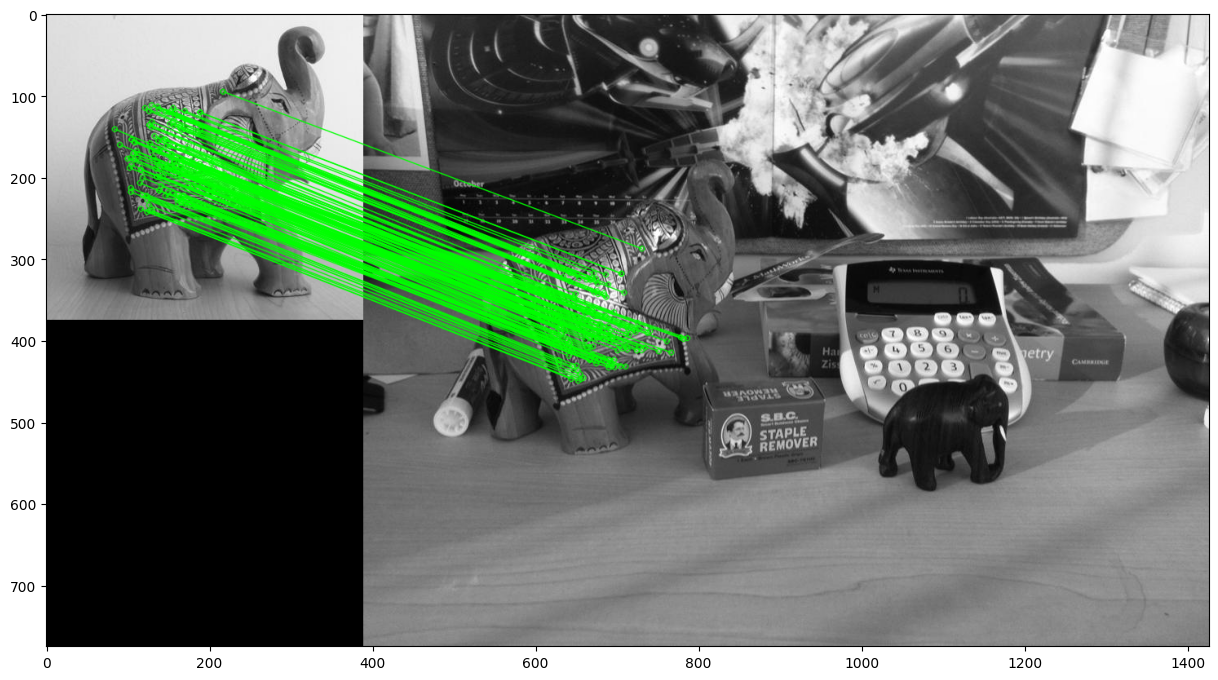

(<matplotlib.image.AxesImage at 0x1398f87b090>, None)

In [27]:
# Load the images
image1 = cv2.imread('data/images/elephantImage.png')
image2 = cv2.imread('data/images/sceneImage.png')

# Initialize the ORB detector
feat = cv2.SIFT_create()

# Find the keypoints and descriptors with ORB
kp1, des1 = feat.detectAndCompute(image1, None)
kp2, des2 = feat.detectAndCompute(image2, None)

# Create BFMatcher (Brute Force Matcher)
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)

# Extract the matched keypoints
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)      # represent each pt as one row with 2 cols (findHomography expects a 3D arr)
                                                                                #   - 1 --> total # of elements in the arr (automatically inferred)
                                                                                #     1 --> each pt is structured as a single row
                                                                                #     2 --> each pt has (x, y) coordinates (2 vals)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

# Use RANSAC to estimate the homography matrix
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransacReprojThreshold=5)
        # cv2.findHomography(src_points, destination_points, method, ransacReprojThreshold, mask, maxIters, confidence)
        #           ransacReprojThreshold --> threshold (max error val) to classify a pt as an inlier
        #           mask --> 1 - inlier, 0 - outlier

# Draw the matching 
draw_params = dict(matchColor = (0,255,0),              # draw matches in green color
                   singlePointColor = None,
                   matchesMask = mask.ravel().tolist(), # draw only inliers
                   flags = 2)                           # flags = 2 --> same as cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS (only draw the matching lines w/o the kp)
                                                        # flags = 4 --> same as cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
plt.figure(figsize=(15,15))
output_image = cv2.drawMatches(image1,kp1,image2,kp2,good,None,**draw_params)
plt.imshow(output_image, 'gray'),plt.show()

### Object recognition: 
We can now locate the object in the image


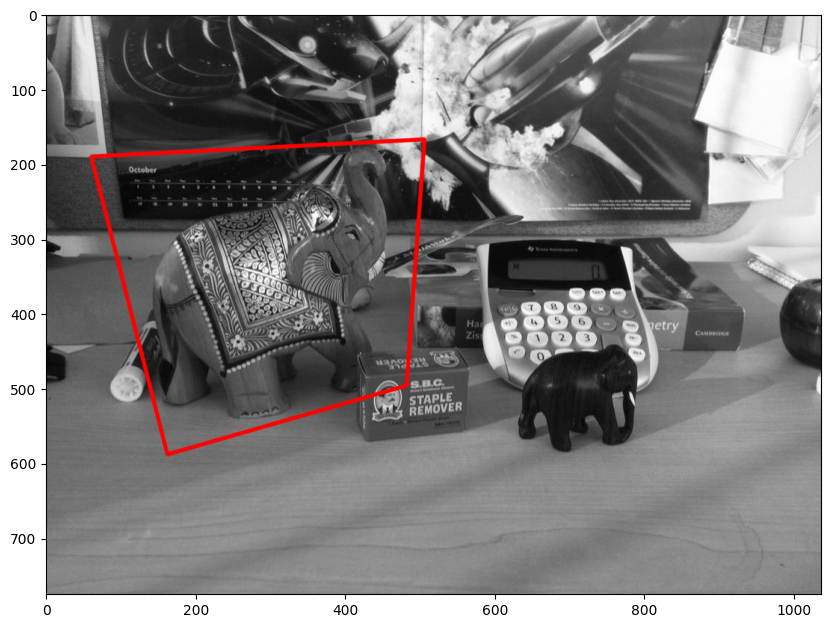

(<matplotlib.image.AxesImage at 0x1398f964650>, None)

In [28]:
h,w = image1.shape[:2]
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)           # four corners, reshape as (n, 1, 2) -- n = # of pts
dst = cv2.perspectiveTransform(pts,H)                                           # use perspectiveTransform if you already have a transformation 
                                                                                # matrix (in our case, H) and you want to apply it to a set of pts
#       cv2.perspectiveTransform(src, m, dst)
output_image = cv2.polylines(image2,[np.int32(dst)],True,255,3, cv2.LINE_AA)    # draws a polygon on image2 corresponding to the transformed pts (dst)
#       cv2.polylines(img, pts, isClosed, color, thickness, lineType)
#               pts --> must be converted to int
#               isClosed --> last pt is connected to first

plt.figure(figsize=(10,10))
plt.imshow(output_image, 'gray'),plt.show()

## Image Stitching
We will follow a nearly identical procedure as in the previous scenario to merge two images, creating a panoramic view.

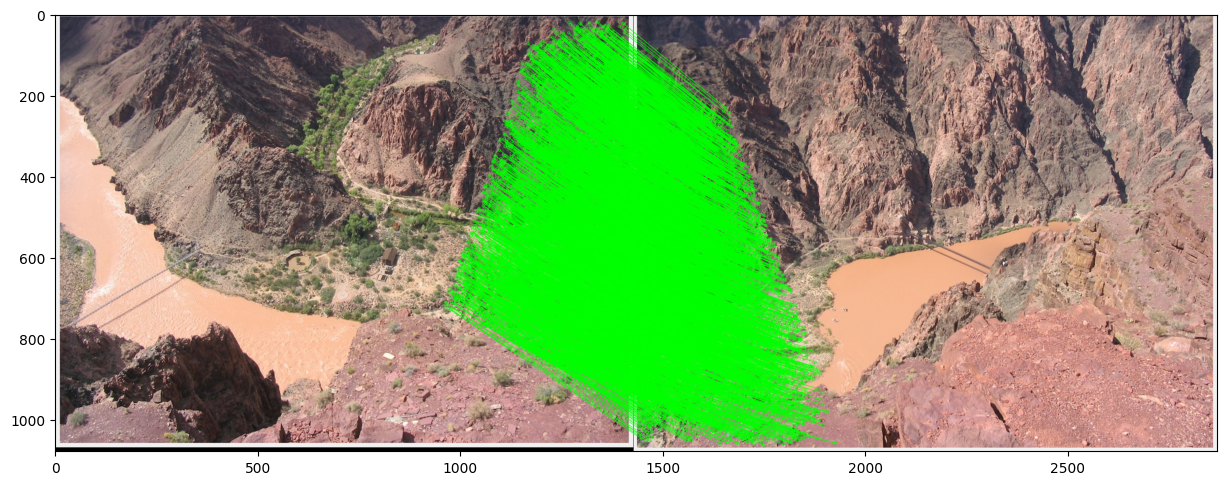

(<matplotlib.image.AxesImage at 0x1398f97b090>, None)

In [29]:
# Load the images
image1 = cv2.imread('data/images/scene1.png')
image2 = cv2.imread('data/images/scene2.png')

# Initialize the ORB detector
feat = cv2.SIFT_create()

# Find the keypoints and descriptors with ORB
kp1, des1 = feat.detectAndCompute(image1, None)
kp2, des2 = feat.detectAndCompute(image2, None)

# Create BFMatcher (Brute Force Matcher)
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)

# Extract the matched keypoints
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

# Use RANSAC to estimate the homography matrix
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransacReprojThreshold=5)

# Draw the matching 
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = mask.ravel().tolist(), # draw only inliers
                   flags = 2)
plt.figure(figsize=(15,15))
output_image = cv2.drawMatches(image1,kp1,image2,kp2,good,None,**draw_params)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)), plt.show()

**And now stitch the two images together**

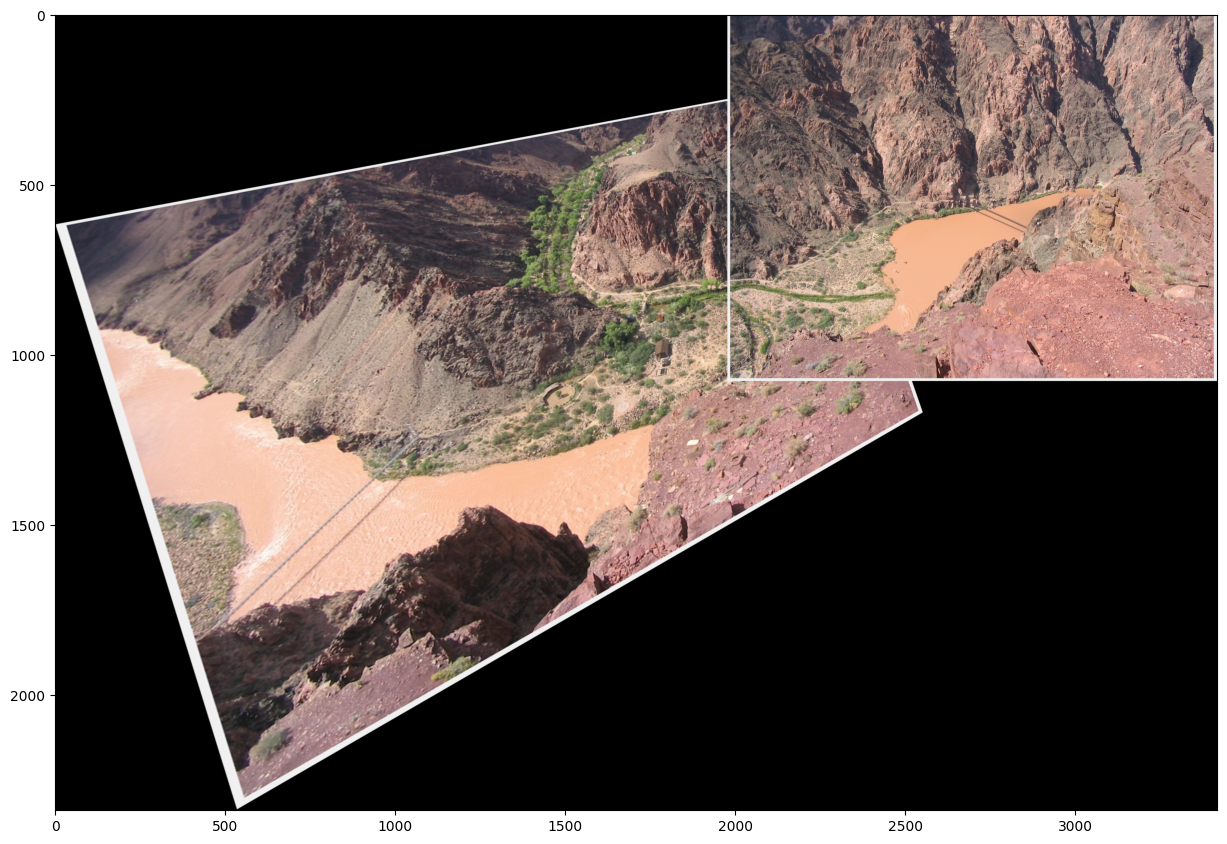

In [30]:
# Find the corners of the transformed image
h1, w1 = image1.shape[:2]
h2, w2 = image2.shape[:2]
corners1 = np.array([[0, 0], [0, h1 - 1], [w1 - 1, h1 - 1], [w1 - 1, 0]], dtype=np.float32).reshape(-1, 1, 2)  # each corner is represented as [[x, y]]     
corners2 = np.array([[0, 0], [0, h2 - 1], [w2 - 1, h2- 1], [w2 - 1, 0]], dtype=np.float32).reshape(-1, 1, 2)

transformed_corners = cv2.perspectiveTransform(corners1, H)                     # only corners 1 undergo transformation
transformed_corners = np.concatenate((transformed_corners, corners2), axis=0)   # concatenate arrs along the rows

# Find the minimum and maximum (transformed) coordinates to get the dimensions of the panoramic image
min_x, min_y = np.int32(transformed_corners.min(axis=0).ravel())                # finding the min & max along the first axis -- (x, y) coordinates
                                                                                # ravel() -- flattens the array results
max_x, max_y = np.int32(transformed_corners.max(axis=0).ravel())

# Adjust the homography matrix to account for the shift
translation_matrix = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]])      # shifting the image by -minx_x & min_y (so that it starts from (0, 0))
adjusted_homography_matrix = np.dot(translation_matrix, H)                      # apply translation to the original homography matrix H

# Apply the adjusted homography to warp the image
stitched_image = cv2.warpPerspective(image1, adjusted_homography_matrix, (max_x - min_x + 1, max_y - min_y + 1))
stitched_image[-min_y:image2.shape[0] - min_y, -min_x:image2.shape[1] - min_x,:] = image2    # overlays image2 onto the stitched image, ensuring that it aligns properly with image1
                                                                                             # the negative indexing is used to ensure correct placement of image2 in the stitched image.

# Display or save the stitched image
plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))

**Note:** You can streamline the entire process by utilizing cv2.Stitcher, which automates the steps mentioned above.